# 목표 : DEG, trajectory
- sample간의 deg (*age*, *control*)
    - control vs LGG2 & LGG3
    - age
- GFP + cell -> cell-cell interaction?
- external dataset : OPC & oligodendrocyte과 integration

### 조건
- control + GFP vs tumor + GFP
- control vs tumor
- tumor cell subcluster 끼리 비교 (OPC-like + Tumor or 새로운 subcluster)
- cell cycle analysis (proliferation vs quiescent cells vs stemness)

In [236]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import os
import pickle as pkl

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

import gseapy as gp
from gseapy.plot import gseaplot
from gseapy import Biomart

from sanbomics.tools import id_map
from sanbomics.plots import volcano

In [4]:
data_path = '/Users/jiehoonk/DevHub/mnt/dataset/lgg/output'
deg_out_path = '/Users/jiehoonk/DevHub/mnt/dataset/lgg/output/deg'
os.makedirs(deg_out_path, exist_ok=True)
!ls {data_path}

1qc.h5ad
adj.csv
annotated.h5ad
annotated_with_cnvs.h5ad
copykat_result_copykat_CNA_raw_results_gene_by_cell.txt
copykat_result_copykat_CNA_results.txt
copykat_result_copykat_prediction.txt
copykat_result_copykat_with_genes_heatmap.pdf
deg
filtered.loom
fin_object.celloracle.oracle
integrated.h5ad
links.celloracle.links
model.model
obj.celloracle.oracle
reg.csv
scenic_out.loom


In [59]:
adata = sc.read_h5ad(os.path.join(data_path, 'annotated_with_cnvs.h5ad'))
adata

AnnData object with n_obs × n_vars = 21172 × 33697
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'sample_description', '_scvi_batch', '_scvi_labels', 'over', 'jw_diagnosis', 'jw_anno', 'ct_anno', 'ct_conf_score', 'GFP', 'leiden_res3', 'tumor_score', '_scvi_raw_norm_scaling', 'Astro-like_score', 'Astrocytes_score', 'Cycling_score', 'Endothelial_score', 'Gradient_score', 'Microglia_score', 'Mixed_score', 'Neurons_score', 'Oligodendrocytes_score', 'OPC-like_score', 'Pericytes_score', 'RE_score', 'T Cell_score', 'cell_type', 'copykat.pred', 'cnv_leiden', 'cnv_score', 'cnv_status', 'mod_cell_type', 'low_cell_type'
    var: 'chromosome', 'start', 'end', 'gene_id', 'gene_name'
    uns: 'GFP_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'cnv', 'cnv_leiden_colors', 'cnv_neighbors',

In [60]:
# change to count matrix
adata.X = adata.layers['counts'].copy()

#### 1.DEG
- control vs LGG : LGG는 나중에 뺴야될듯 ? 
- control vs HGG
- LGG vs HGG

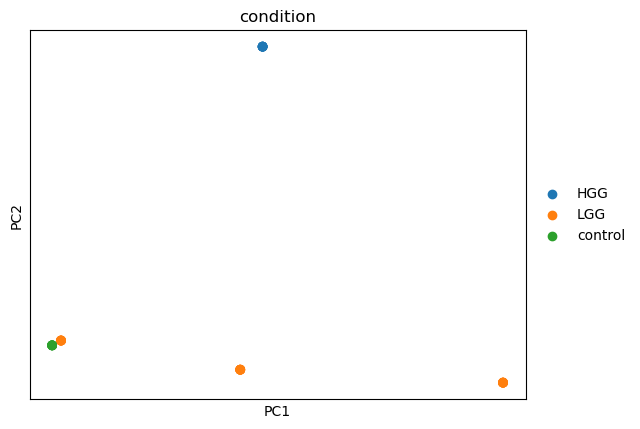

In [106]:
from IPython.display import Image, display
display(Image(filename='../plot/deg_lgg2.png'))

In [ ]:
adata.obs.sample_id = adata.obs.sample_id.cat.reorder_categories(['Control', 'LGG_1',"LGG_2", "LGG_3", 'HGG'])

In [123]:
adata.obs.sample_id.unique()

['LGG_1', 'HGG', 'LGG_2', 'LGG_3', 'Control']
Categories (5, object): ['Control', 'HGG', 'LGG_1', 'LGG_2', 'LGG_3']

In [130]:
c_lgg = adata[adata.obs.sample_id != "HGG"] # 14000
c_hgg = adata[adata.obs.sample_id.isin(["Control", "HGG"])] # 7000
lgg_hgg = adata[adata.obs.sample_id != "Control"] # 20000

In [146]:
# create pseudobulk & replicates
def do_pseudobulk(adata):
    pseudobulk = []
    for sample in adata.obs.sample_id.unique():
        sample_cell_subset = adata[adata.obs['sample_id'] == sample]
        
        idx = list(sample_cell_subset.obs_names)
        random.shuffle(idx)
        idx = np.array_split(np.array(idx), 5) # 5 pseudo-replicates per each
        
        for i, pr in enumerate(idx):
            rep_adata = sc.AnnData(X = sample_cell_subset.X.sum(axis = 0), 
                                var = sample_cell_subset.var[[]])
            rep_adata.obs_names = [sample + "-" + str(i)]
            if "LGG" in sample:
                condition = 'LGG'
            elif "HGG" in sample:
                condition = "HGG"
            else:
                condition = "control"
            rep_adata.obs['condition'] = condition
            rep_adata.obs['replicate'] = i
            pseudobulk.append(rep_adata)
    pb = sc.concat(pseudobulk)
    counts_df = pd.DataFrame(pb.X, columns=pb.var_names)
    inference = DefaultInference()
    dds = DeseqDataSet(
        counts = counts_df,
        metadata = pb.obs,
        design_factors = ['condition'],
        refit_cooks= True,
        inference = inference,
        n_cpus=None
    )
    sc.pp.filter_genes(dds, min_cells=1)
    dds.deseq2()
    sc.tl.pca(dds, layer="normed_counts")
    fig = sc.pl.pca(dds, color = 'condition', size = 200, show=False)
    stat_res = DeseqStats(dds, inference=inference)
    stat_res.summary()
    de = stat_res.results_df
    
    return dds, de, fig

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 0.84 seconds.

Fitting dispersion trend curve...
/Users/jiehoonk/micromamba/envs/deg/lib/python3.10/site-packages/pydeseq2/dds.py:590: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend()
... done in 0.26 seconds.

Fitting MAP dispersions...
... done in 1.23 seconds.

Fitting LFCs...
... done in 0.78 seconds.

Replacing 0 outlier genes.

Running Wald tests...


Log2 fold change & Wald test p-value: condition control vs LGG
                       baseMean  log2FoldChange     lfcSE       stat  \
Xkr4                4045.864023       -0.321965  0.165934  -1.940317   
Gm1992               107.406720        0.228053  0.122925   1.855228   
Gm19938              253.000715       -0.256577  0.239963  -1.069235   
Gm37381                0.764933        0.217525  1.674427   0.129910   
Rp1                   13.718217        0.510000  0.417711   1.220939   
...                         ...             ...       ...        ...   
Csprs                  1.891729       -1.380831  1.613858  -0.855608   
ENSMUSG00000096808     0.203401        0.629236  1.892616   0.332469   
ENSMUSG00000095742     6.823576        1.430975  0.540888   2.645602   
ENSMUSG00000095041  4115.007773       -2.026371  0.061944 -32.712937   
Cas9-EGFP            803.937986       -2.773907  0.135805 -20.425701   

                           pvalue           padj  
Xkr4                 

... done in 0.64 seconds.



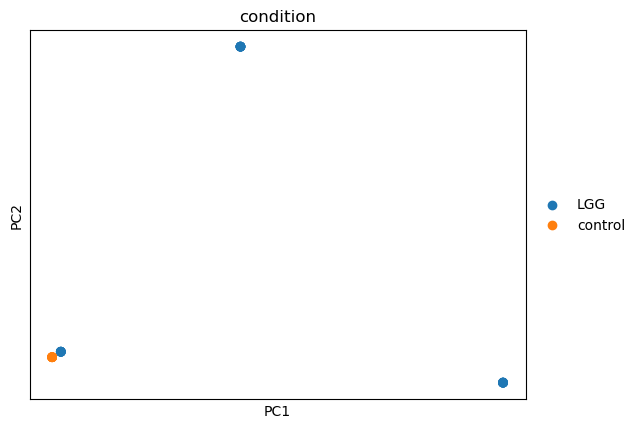

In [185]:
dds, de, fig = do_pseudobulk(c_lgg)

In [186]:
mapper = id_map(species='mouse')
def map_ids(gene):
    if gene in mapper.mapper.keys():
        return mapper.mapper[gene]
    else:
        return gene
de["Symbol"] = de.index.map(map_ids)

de = de[de.baseMean >= 10]
sigs = de[(de.padj < 0.05) & (abs(de.log2FoldChange) > 1)]
sigs

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol
Sox17,42.688008,3.200855,0.477731,6.700118,2.082520e-11,3.081347e-10,Sox17
A930006A01Rik,14.227172,1.996987,0.286144,6.978971,2.973490e-12,5.156642e-11,A930006A01Rik
St18,11109.081153,1.220516,0.384743,3.172294,1.512401e-03,4.035310e-03,St18
Gm26901,152.473765,-1.317887,0.274322,-4.804155,1.554068e-06,8.892955e-06,Gm26901
Rrs1,999.173164,-1.159721,0.191654,-6.051128,1.438352e-09,1.528620e-08,Rrs1
...,...,...,...,...,...,...,...
Ddx3y,843.900328,2.400943,0.645504,3.719486,1.996289e-04,6.702530e-04,Ddx3y
Gm47283,3613.585266,-1.168771,0.335355,-3.485179,4.918077e-04,1.498135e-03,Gm47283
mt-Nd3,4436.349616,1.082643,0.091901,11.780495,4.920317e-32,7.424081e-30,mt-Nd3
ENSMUSG00000095041,4115.007773,-2.026371,0.061944,-32.712937,1.022543e-234,8.588675e-231,AC149090.1


#### 2. GSEA
- manual or gene ontology

In [ ]:
#### Gene ontology candidates
neural_progenitor_cell_maintenance = {
    "Neurogenesis": "GO:0022008",
    "Neuron fate commitment": "GO:0048663",
    "Neuron development": "GO:0048666"
}

glioma_and_tumor_development = {
    "Apoptotic process involved in morphogenesis": "GO:0010623",
    "Positive regulation of cell migration": "GO:0030335",
    "Negative regulation of cell proliferation": "GO:0008285"
}

stem_cell_maintenance_and_differentiation = {
    "Stem cell maintenance": "GO:0019827",
    "Stem cell differentiation": "GO:0048863",
    "Cell fate commitment": "GO:0045165"
}

cell_cycle_and_division = {
    "Cell cycle": "GO:0007049",
    "Cell division": "GO:0051301",
    "Chromosome segregation": "GO:0007059"
}

signal_transduction_pathways = {
    "Signal transduction": "GO:0007165",
    "Neurotrophin TRK receptor signaling pathway": "GO:0048011",
    "Smoothened signaling pathway": "GO:0007224"
}

microenvironment_interaction = {
    "Skeletal system development": "GO:0001501",
    "Regulation of locomotion": "GO:0040012",
    "Cell-cell signaling": "GO:0007267"
}

In [ ]:
# gene ontology
gp.get_library_name()

In [202]:
bm = Biomart()
h2m = bm.query(dataset='hsapiens_gene_ensembl',
               attributes=['ensembl_gene_id','external_gene_name',
                           'mmusculus_homolog_ensembl_gene',
                           'mmusculus_homolog_associated_gene_name'])

In [206]:
library = gp.get_library('GO_Biological_Process_2023')

In [210]:
h2m_dict = {}
for i, row in h2m.loc[:,["external_gene_name", "mmusculus_homolog_associated_gene_name"]].iterrows():
    if row.isna().any(): continue
    h2m_dict[row['external_gene_name']] = row["mmusculus_homolog_associated_gene_name"]

gene_sets = {}
for term, genes in library.items():
    new_genes = []
    for gene in genes:
        if gene in h2m_dict:
            new_genes.append(h2m_dict[gene])
    gene_sets[term] = new_genes

In [194]:
rnk = de[['stat']].dropna().sort_values('stat', ascending=False)

In [211]:
pre_res = gp.prerank(rnk = rnk, gene_sets = gene_sets, min_size = 5, max_size = 1000, seed = 6, permutation_num=1000)

2024-05-15 19:43:39,501 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [216]:
out = []
for term in list(pre_res.results):
    out.append([term, pre_res.results[term]['fdr'], pre_res.results[term]['es'], pre_res.results[term]['nes'],])
out_df = pd.DataFrame(out, columns=['term', 'fdr', 'Enrichment_Score', 'Normalized_Enrichment_Score', ]).sort_values('fdr').reset_index(drop=True)
out_df

,term,fdr,Enrichment_Score,Normalized_Enrichment_Score
0,Macrophage Activation (GO:0042116),0.000000,0.697899,2.750612
1,Negative Regulation Of Mitotic Metaphase/Anaph...,0.000000,-0.743848,-2.531594
2,Cytoplasmic Translation (GO:0002181),0.000000,-0.660736,-2.820326
3,Regulation Of Tumor Necrosis Factor Production...,0.000000,0.546395,2.731064
4,Ribosomal Small Subunit Biogenesis (GO:0042274),0.000000,-0.610544,-2.685432
...,...,...,...,...
4818,Regulation Of Respiratory Gaseous Exchange (GO...,0.999369,0.199061,0.430799
4819,Regulation Of Fertilization (GO:0080154),0.999503,0.189479,0.411025
4820,Oligosaccharide-Lipid Intermediate Biosyntheti...,0.999504,0.139062,0.397065
4821,ER Overload Response (GO:0006983),0.999910,-0.147753,-0.351520


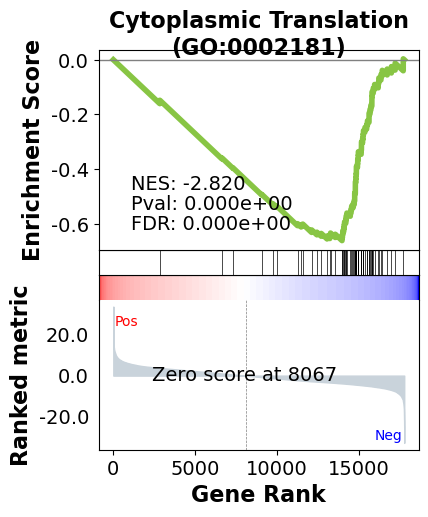

In [221]:
terms = pre_res.res2d.Term
axs = pre_res.plot(terms=terms[1]) 

#### 3. Heatmap

In [225]:
dds.layers['log1p'] = np.log1p(dds.layers['normed_counts'])
dds_sigs = dds[:, sigs.index]

In [ ]:
dds_sigs.obs_names

In [226]:
df_graph = pd.DataFrame(dds_sigs.layers['log1p'].T, index = dds_sigs.var_names, columns = dds_sigs.obs_names)
df_graph

,LGG_1-0,LGG_1-1,LGG_1-2,LGG_1-3,LGG_1-4,LGG_2-0,LGG_2-1,LGG_2-2,LGG_2-3,LGG_2-4,LGG_3-0,LGG_3-1,LGG_3-2,LGG_3-3,LGG_3-4,Control-0,Control-1,Control-2,Control-3,Control-4
Sox17,1.728061,1.728061,1.728061,1.728061,1.728061,2.379371,2.379371,2.379371,2.379371,2.379371,3.304640,3.304640,3.304640,3.304640,3.304640,4.875850,4.875850,4.875850,4.875850,4.875850
A930006A01Rik,2.104353,2.104353,2.104353,2.104353,2.104353,1.774792,1.774792,1.774792,1.774792,1.774792,2.431282,2.431282,2.431282,2.431282,2.431282,3.567683,3.567683,3.567683,3.567683,3.567683
St18,9.186938,9.186938,9.186938,9.186938,9.186938,9.419549,9.419549,9.419549,9.419549,9.419549,7.978923,7.978923,7.978923,7.978923,7.978923,9.874358,9.874358,9.874358,9.874358,9.874358
Gm26901,5.559720,5.559720,5.559720,5.559720,5.559720,4.733372,4.733372,4.733372,4.733372,4.733372,5.116626,5.116626,5.116626,5.116626,5.116626,4.299933,4.299933,4.299933,4.299933,4.299933
Rrs1,7.266178,7.266178,7.266178,7.266178,7.266178,6.637000,6.637000,6.637000,6.637000,6.637000,7.158885,7.158885,7.158885,7.158885,7.158885,6.256406,6.256406,6.256406,6.256406,6.256406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ddx3y,6.816233,6.816233,6.816233,6.816233,6.816233,4.130969,4.130969,4.130969,4.130969,4.130969,5.520498,5.520498,5.520498,5.520498,5.520498,7.675575,7.675575,7.675575,7.675575,7.675575
Gm47283,8.727763,8.727763,8.727763,8.727763,8.727763,7.486757,7.486757,7.486757,7.486757,7.486757,8.441190,8.441190,8.441190,8.441190,8.441190,7.532682,7.532682,7.532682,7.532682,7.532682
mt-Nd3,8.314052,8.314052,8.314052,8.314052,8.314052,8.011809,8.011809,8.011809,8.011809,8.011809,8.102097,8.102097,8.102097,8.102097,8.102097,8.902568,8.902568,8.902568,8.902568,8.902568
ENSMUSG00000095041,8.585501,8.585501,8.585501,8.585501,8.585501,8.565581,8.565581,8.565581,8.565581,8.565581,8.437761,8.437761,8.437761,8.437761,8.437761,7.126460,7.126460,7.126460,7.126460,7.126460


/Users/jiehoonk/micromamba/envs/deg/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/jiehoonk/micromamba/envs/deg/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


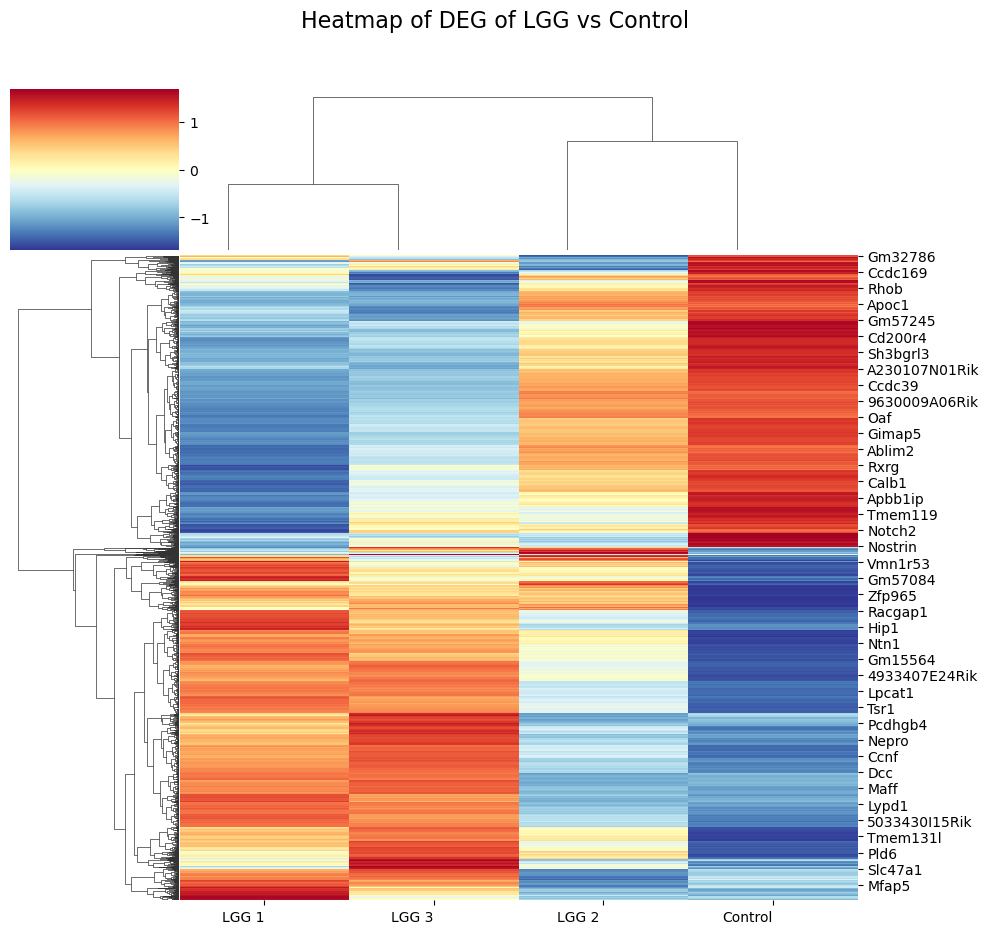

In [251]:
g = sns.clustermap(df_graph, z_score= 0, cmap = "RdYlBu_r")
unique_labels = ["LGG 1", "LGG 2 ", "LGG 3", "Control"]
positions = [3-0.5, 13-0.5, 8-0.5, 18-0.5]

g.ax_heatmap.set_xticklabels([])
g.ax_heatmap.set_xticks(positions)
g.ax_heatmap.set_xticklabels(unique_labels)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation = 0, ha="right")

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Heatmap of DEG of LGG vs Control", x=0.5, ha='center', fontsize=16)
plt.show()

- plot with markers

In [239]:
markers_from_paper = pd.read_csv('../astrocytoma_markers.csv')
for col in markers_from_paper.columns:
    markers_from_paper[col] = markers_from_paper[col].apply(lambda x:x.capitalize())
markers_from_paper = {cell : [m for m in mk if m in adata.var.index] for cell, mk in markers_from_paper.items()}
markers_from_paper.keys()

dict_keys(['Astro-like', 'Astrocytes', 'Cycling', 'Endothelial', 'Gradient', 'Microglia', 'Mixed', 'Neurons', 'Oligodendrocytes', 'OPC-like', 'Pericytes', 'RE', 'T Cell'])

- plot "OPC-like" markers

In [244]:
coi = "OPC-like"
mks = markers_from_paper[coi]
dds_sub = dds[:, sigs[sigs.index.isin(mks)].index] # res for DE
df_sub = pd.DataFrame(dds_sub.layers['log1p'].T, index = dds_sub.var_names, columns = dds_sub.obs_names)
df_sub

,LGG_1-0,LGG_1-1,LGG_1-2,LGG_1-3,LGG_1-4,LGG_2-0,LGG_2-1,LGG_2-2,LGG_2-3,LGG_2-4,LGG_3-0,LGG_3-1,LGG_3-2,LGG_3-3,LGG_3-4,Control-0,Control-1,Control-2,Control-3,Control-4
Tmeff2,8.538079,8.538079,8.538079,8.538079,8.538079,9.792676,9.792676,9.792676,9.792676,9.792676,8.774171,8.774171,8.774171,8.774171,8.774171,10.220783,10.220783,10.220783,10.220783,10.220783
Sphkap,3.162695,3.162695,3.162695,3.162695,3.162695,4.090816,4.090816,4.090816,4.090816,4.090816,3.599916,3.599916,3.599916,3.599916,3.599916,4.959788,4.959788,4.959788,4.959788,4.959788
Brinp2,7.115553,7.115553,7.115553,7.115553,7.115553,6.941868,6.941868,6.941868,6.941868,6.941868,7.232236,7.232236,7.232236,7.232236,7.232236,6.156138,6.156138,6.156138,6.156138,6.156138
Col20a1,5.816764,5.816764,5.816764,5.816764,5.816764,4.816050,4.816050,4.816050,4.816050,4.816050,6.381928,6.381928,6.381928,6.381928,6.381928,4.904619,4.904619,4.904619,4.904619,4.904619
Myt1,7.494345,7.494345,7.494345,7.494345,7.494345,7.113316,7.113316,7.113316,7.113316,7.113316,7.673096,7.673096,7.673096,7.673096,7.673096,6.306502,6.306502,6.306502,6.306502,6.306502
Sh3d19,9.163657,9.163657,9.163657,9.163657,9.163657,8.363500,8.363500,8.363500,8.363500,8.363500,9.234672,9.234672,9.234672,9.234672,9.234672,8.235753,8.235753,8.235753,8.235753,8.235753
Lhfpl3,11.122818,11.122818,11.122818,11.122818,11.122818,10.072721,10.072721,10.072721,10.072721,10.072721,11.344878,11.344878,11.344878,11.344878,11.344878,9.362845,9.362845,9.362845,9.362845,9.362845
Hip1,9.217227,9.217227,9.217227,9.217227,9.217227,8.366352,8.366352,8.366352,8.366352,8.366352,8.823373,8.823373,8.823373,8.823373,8.823373,8.122050,8.122050,8.122050,8.122050,8.122050
Dll3,8.695148,8.695148,8.695148,8.695148,8.695148,7.897513,7.897513,7.897513,7.897513,7.897513,8.389996,8.389996,8.389996,8.389996,8.389996,6.741176,6.741176,6.741176,6.741176,6.741176
Igsf9b,7.581692,7.581692,7.581692,7.581692,7.581692,6.934740,6.934740,6.934740,6.934740,6.934740,7.874181,7.874181,7.874181,7.874181,7.874181,6.306502,6.306502,6.306502,6.306502,6.306502


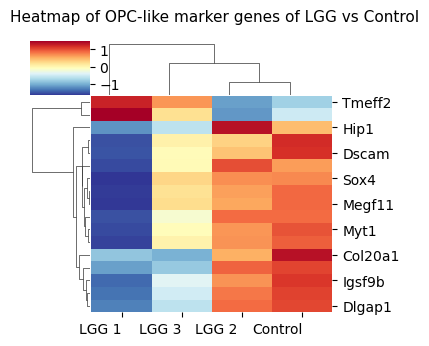

In [254]:
g = sns.clustermap(df_sub, z_score= 0, cmap = "RdYlBu_r", figsize = (4,4))
unique_labels = ["LGG 1", "LGG 2 ", "LGG 3", "Control"]
positions = [3-0.5, 13-0.5, 8-0.5, 18-0.5]

g.ax_heatmap.set_xticklabels([])
g.ax_heatmap.set_xticks(positions)
g.ax_heatmap.set_xticklabels(unique_labels)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation = 0, ha="right")

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Heatmap of OPC-like marker genes of LGG vs Control", x=0.5, ha='center', fontsize=11)
plt.show()

#### 4. Volcano plot
- pyDeSeq output

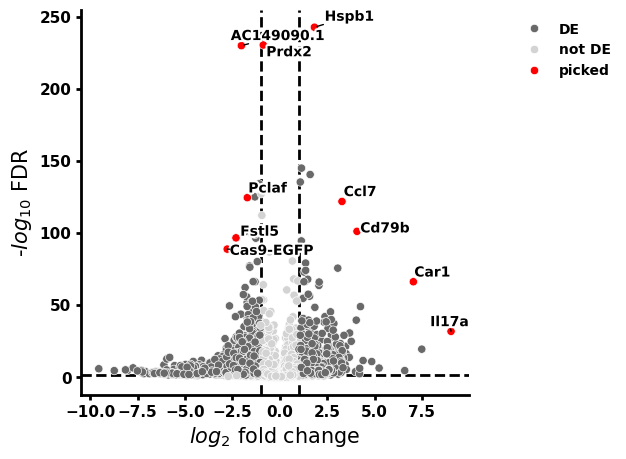

In [268]:
volcano(de, symbol="Symbol", log2fc_thresh = 1,  colors = ["dimgrey", "lightgrey", "red"])

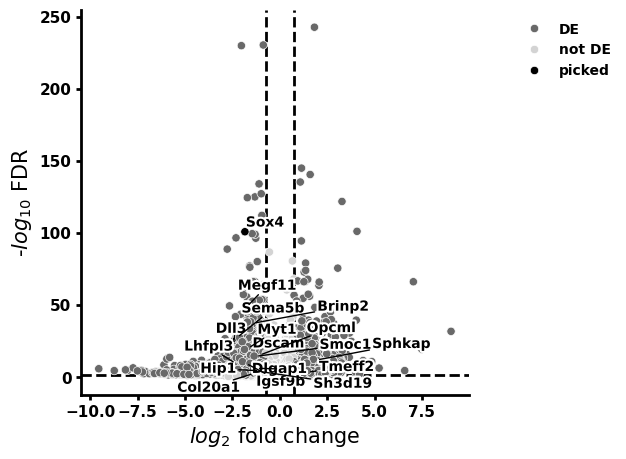

In [259]:
# OPC-like
volcano(de, symbol="Symbol", to_label = df_sub.index)

In [ ]:
adata.obs['condition']